In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import bioframe
import cooler

import cooltools
from cooltools.lib.numutils import adaptive_coarsegrain
from cooltools.lib.plotting import *

import multiprocess as mp
num_cores = mp.cpu_count()


import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
import logging, matplotlib
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

## parameters for nice plots
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'fall'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 10

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import read_and_average_genomic_exp

In [3]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"

data_dir = "/project/fudenber_735/akitaX1_analyses_data/genomic_disruption/disruption_by_permutation"

In [14]:
# reading data, averaging over targets
df = read_and_average_genomic_exp(data_dir, stat_to_average=stat_of_analysis_interest)

reading h5 files to dataframes
averaging over targets
collecting data for SCD


In [15]:
df = df.sort_values(by="SCD", ascending=False)

In [8]:
# let's focus on impactful sites (with SCD>=15)
# df = df[df["SCD"] >= 20]

In [ ]:
# of_interest = df[:16]
of_interest = df[300:][:16]

In [ ]:
# analysis parameters

res = 10_000 ## common resolution for analyzing TADs/dots

genome_folder = '/project/fudenber_735/genomes/mm10/'
genome_fasta = genome_folder+'mm10.fa'
genome_chromsizes = genome_folder+'mm10.chrom.sizes.reduced'
                         
# high-resolution reprocessed publically-available data from Bonev et al. 2017
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))

# view for analyzing only autosomes, extracted from cooler chromsizes
view_df = cooltools.lib.make_cooler_view(bonev_cooler)[:19]

In [ ]:
plt_width = 4
num_plots = 4
c=0
fig = plt.figure(figsize=(num_plots*plt_width, num_plots*(plt_width+1)))

padding = 2000000
smoothed = '_smoothed'
fetch_region = True

for s in of_interest.itertuples():
    chrom = s.chrom 
    start = s.start 
    end = s.end
    mseq_str = '%s:%d-%d' % (chrom, start-padding, end+padding)

    if fetch_region:
        mat = bonev_cooler.matrix(balance=True).fetch(mseq_str)
    
    if smoothed == '_smoothed': 
        mat = adaptive_coarsegrain(mat,  mat,  cutoff=2, max_levels=2)

    c+=1
    plt.subplot(num_plots,num_plots,c)
    vm = np.log10(np.nanmedian(np.diag(mat,3))*.5)

    im = plt.matshow(
        np.log10(mat),
        vmin=vm-2.5, vmax=vm+.25, fignum=False) 
    
    plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(counts)')
    plt.title(mseq_str , y=1.2)
    plt.grid(False)
    plt.xticks(rotation=90)
    

In [ ]:
boundaries_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation"

In [ ]:
boundaries = pd.read_csv(boundaries_file, sep="\t")

In [ ]:
window_size = boundaries_file.split("window_")[1].split(".")[0]
boundary_key, insulation_key = (
    f"boundary_strength_{window_size}",
    f"log2_insulation_score_{window_size}",
)

In [ ]:
boundary_strength_thresh = 0.25
boundary_insulation_thresh = 0

In [ ]:
boundaries = boundaries.iloc[
        (boundaries[boundary_key].values > boundary_strength_thresh)
        * (
            boundaries[insulation_key].values
            < boundary_insulation_thresh
        )
    ]

In [ ]:
plt_width = 4
num_plots = 4
c=0
fig = plt.figure(figsize=(num_plots*plt_width, num_plots*(plt_width+1)))

padding = 2000000
smoothed = '_smoothed'
fetch_region = True

for s in of_interest.itertuples():
    chrom = s.chrom 
    start = s.start 
    end = s.end
    mseq_str = '%s:%d-%d' % (chrom, start-padding, end+padding)
    region_boundaries = bioframe.select(boundaries, mseq_str, cols=['chrom','start','end'])
    
    if fetch_region:
        mat = bonev_cooler.matrix(balance=True).fetch(mseq_str)
    
    if smoothed == '_smoothed': 
        mat = adaptive_coarsegrain(mat,  mat,  cutoff=2, max_levels=2)

    c+=1
    plt.subplot(num_plots,num_plots,c)
    vm = np.log10(np.nanmedian(np.diag(mat,3))*.5)

    im = plt.matshow(
        np.log10(mat),
        vmin=vm-2.5, vmax=vm+.25, fignum=False) 

    # Adding vertical and horizontal lines in the middle
    # where CTCF is
    midpoint = np.shape(mat)[0] / 2  # Assuming mat is a square matrix
    plt.axvline(x=midpoint, color='blue', linestyle='--')
    plt.axhline(y=midpoint, color='blue', linestyle='--')
    
    for boundary_index in range(len(region_boundaries)):
        boundary_start_bin, boundary_end_bin = ((region_boundaries[['start','end']].iloc[boundary_index].values.astype(int) - (start-padding)) //res )
        for boundary_bin in range(boundary_start_bin, boundary_end_bin):
            plt.axvline(x=boundary_bin, color='green', alpha=0.4)
            plt.axhline(y=boundary_bin, color='green', alpha=0.4)
    
    plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(counts)')
    plt.title(mseq_str , y=1.2)
    plt.grid(False)
    plt.xticks(rotation=90)

In [ ]:
for s in of_interest.itertuples():
    chrom = s.chrom 
    start = s.start 
    end = s.end
    print(chrom + ":" + str(start) + "-" + str(end))
    half_res = 10000
    CTCF_in_boundary = df[(df["chrom"] == chrom) & (df["start"] >= start - half_res) & (df["end"] <= end + half_res)].sort_values(by="start", ascending=False)
    for site in CTCF_in_boundary.itertuples():
        print(site.SCD, site.strand)
    print()

In [18]:
df_of_interest = df[:500]

In [19]:
half_res = 10000

In [20]:
num_sites_in_boundary = []
orient_sites_in_boundary = []
scd_sites_in_boundary = []

for s in df_of_interest.itertuples():
    chrom = s.chrom 
    start = s.start 
    end = s.end
    CTCF_in_boundary = df[(df["chrom"] == chrom) & (df["start"] >= start - half_res) & (df["end"] <= end + half_res)].sort_values(by="start", ascending=False)
    num_sites_in_boundary.append(len(CTCF_in_boundary))
    orientation = ""
    scd = []
    
    for ctcf_site in CTCF_in_boundary.itertuples():
        orientation = orientation + str(ctcf_site.strand)
        scd.append(ctcf_site.SCD)

    orient_sites_in_boundary.append(orientation)
    scd_sites_in_boundary.append(scd)


In [21]:
df_of_interest["num_sites"] = num_sites_in_boundary
df_of_interest["orient"] = orient_sites_in_boundary
df_of_interest["scd"] = scd_sites_in_boundary

/tmp/SLURM_21363159/ipykernel_46350/3154787489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_interest["num_sites"] = num_sites_in_boundary
/tmp/SLURM_21363159/ipykernel_46350/3154787489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_interest["orient"] = orient_sites_in_boundary
/tmp/SLURM_21363159/ipykernel_46350/3154787489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

0 100
100 200
200 300
300 400


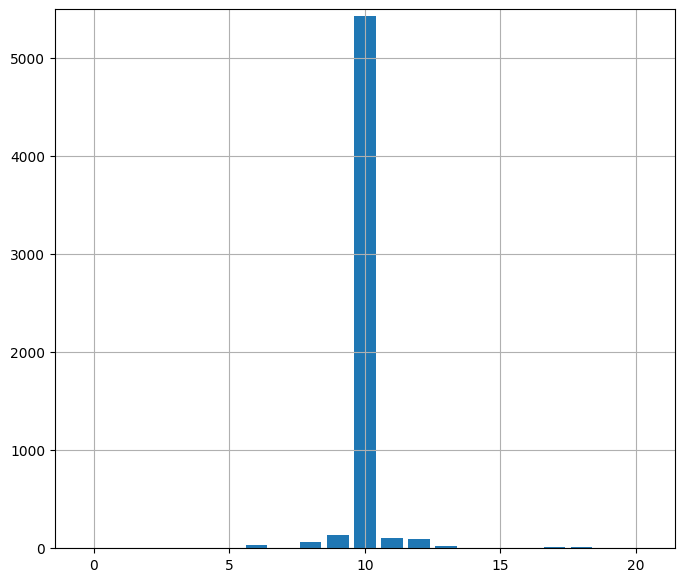

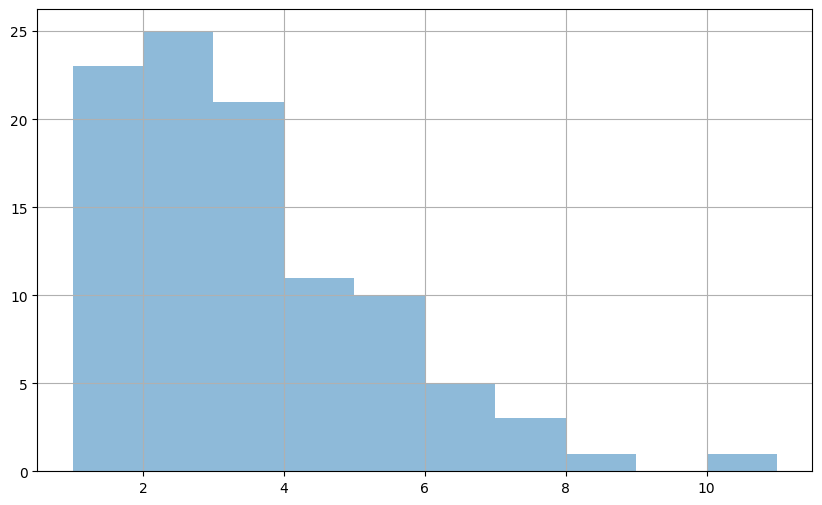

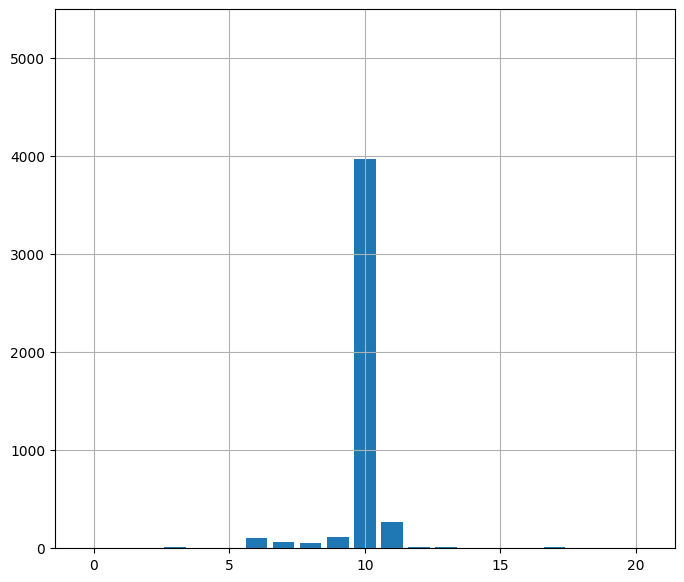

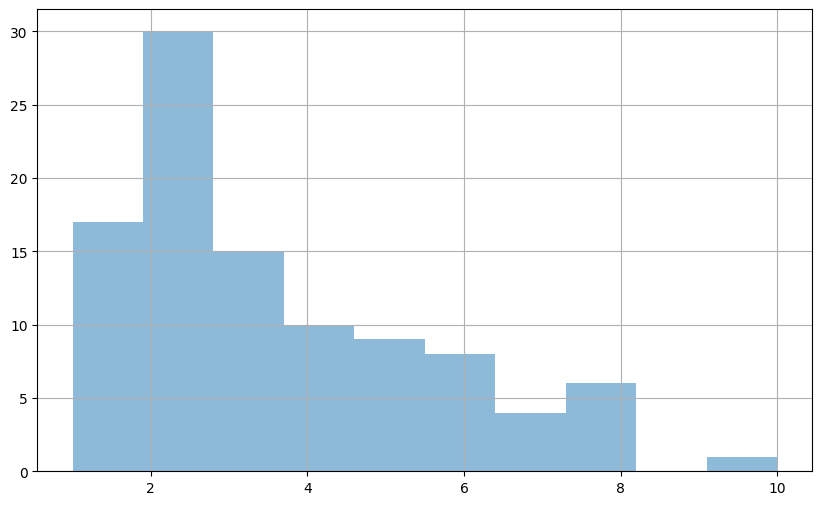

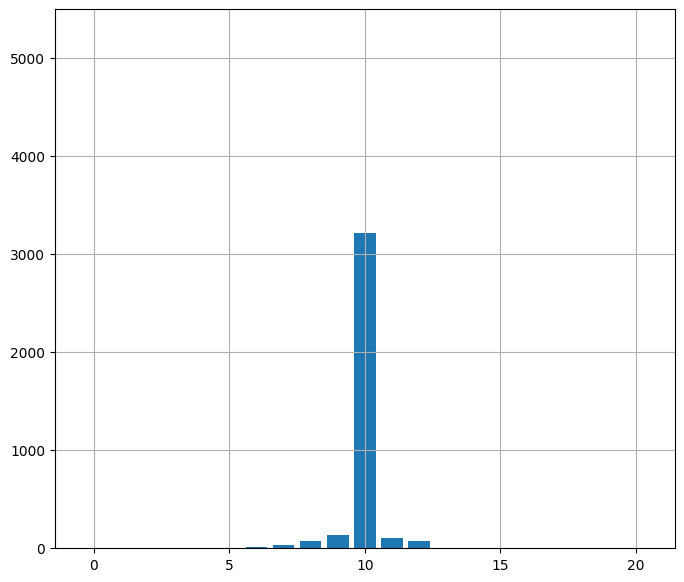

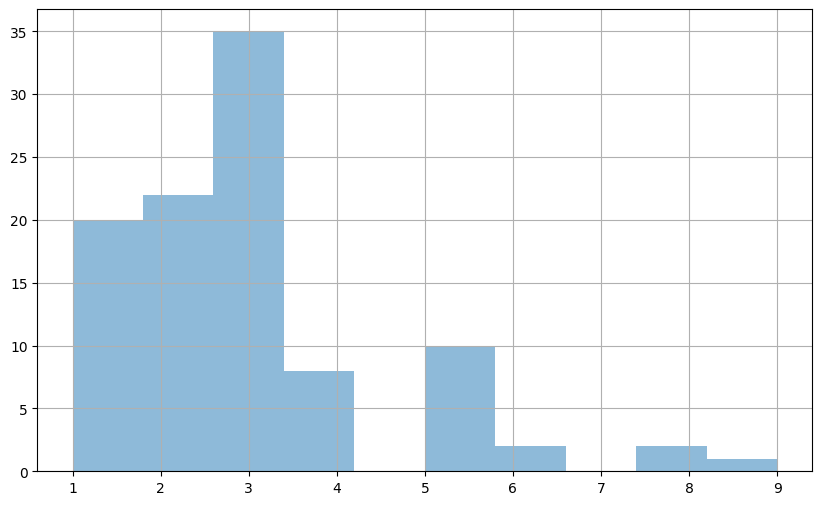

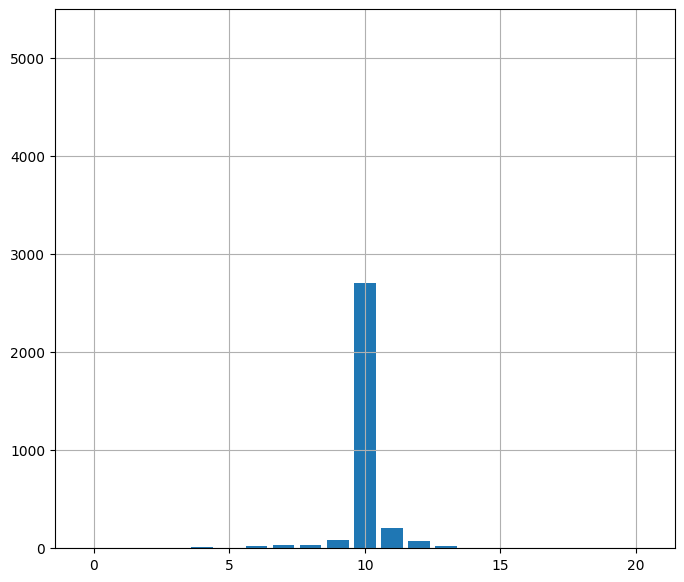

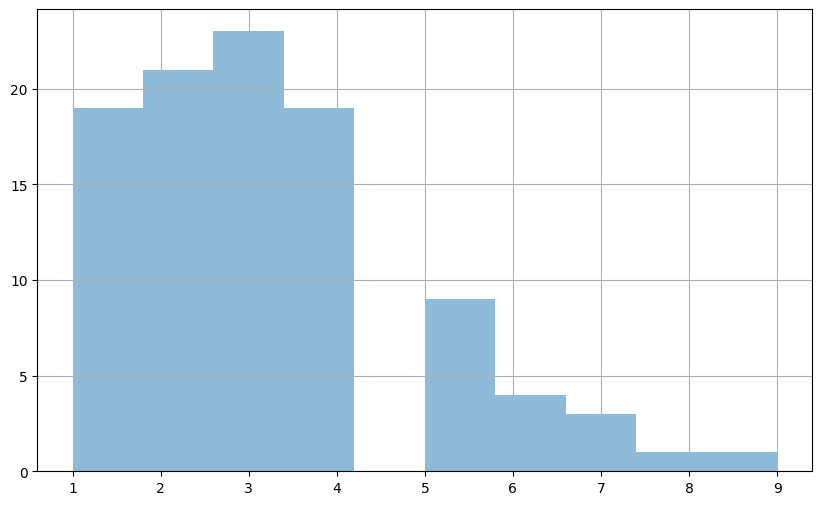

In [27]:
# Define the row intervals
intervals = [100, 200, 300, 400] # Starting with the first 100, then next 200, etc.
# intervals = [100]

# Variable to keep track of the starting index for each interval
start_index = 0

for i, interval in enumerate(intervals, start=1):
    end_index = start_index + 100
    chunk = df_of_interest.iloc[start_index:end_index]
    print(start_index, end_index)
    cummulative_vector = np.zeros((21))

    for ctcf_site in chunk.itertuples():
        scd_array = ctcf_site.scd
        max_index = np.argmax(ctcf_site.scd)
        start = 10-max_index
        vector_len = len(scd_array)
        cummulative_vector[start:start+vector_len] += scd_array

    # print(start_index, end_index)
    plt.figure(figsize=(8, 7))
    plt.bar([i for i in range(21)], cummulative_vector)
    plt.ylim(0, 5500)
    
    # Prepare figure for plotting
    plt.figure(figsize=(10, 6))
    
    # Plot the histogram for the current chunk
    plt.hist(chunk['num_sites'], bins=10, alpha=0.5, label=f'Rows {start_index+1} to {end_index}')
    
    start_index = end_index

# # Adding some plot details
# plt.title('Histogram of num_sites for Different Row Intervals')
# plt.xlabel('Number of Sites')
# plt.ylabel('Frequency')
# plt.legend()

# # Show the plot
# plt.tight_layout()
# plt.show()